## Instalación de OpenMC

In [0]:
#
# Executing this cell you will install OpenMC and the nuclear
# data libraries in this instance of the Google Colaboratory virtual machine.
# The process takes about 2 minutes.
#

def install_openmc():
  #
  # Clone source code from Github, make and install
  #
  
  import os
  
  if not os.path.isdir('/content'):
    print("Esta función instala OpenMC en una instancia de Google Colaboratory.")
    print("Para instalar localmente siga las instrucciones de la documentacion:")
    print("http://docs.openmc.org/en/stable/quickinstall.html")
    return
  
  %cd -q /content
  print("Obtaining OpenMC source code from Github...")
  !git  --no-pager clone https://github.com/mit-crpg/openmc.git &> /dev/null
  %cd -q openmc
  !git --no-pager checkout master &> /dev/null
  !mkdir build
  %cd -q build
  print("Running cmake...")
  !cmake ../ -DPYTHON_EXECUTABLE=/usr/bin/python3 -DCMAKE_INSTALL_PREFIX=/usr/local &> /dev/null
  print("Running make...")
  !make -j &> /dev/null
  print("Running make install...")
  !make install &> /dev/null
  import sys
  sys.path.append('/usr/local/lib/python3.6/dist-packages/openmc-0.10.0-py3.6-linux-x86_64.egg')
  sys.path.append('/usr/local/lib/python3.6/site-packages/')
  %cd -q /content

def install_data_from_onedrive():
  #
  # Download preprocessed HDF5 files from OneDrive (faster).
  #
  import os
  
  if not os.path.isdir('/content'):
    print("Esta función instala los datos nucleares de OpenMC en una instancia de Google Colaboratory.")
    print("Para instalar localmente siga las instrucciones de la documentacion:")
    print("http://docs.openmc.org/en/stable/quickinstall.html")
    return
  %cd -q /content
  print("Obtaining HDF5 files from OneDrive...")
  !wget -O nndc_hdf5.tar.gz "https://onedrive.live.com/download?cid=22422A8EEA2A85B9&resid=22422A8EEA2A85B9%21105&authkey=AHL6xwYFXDwEzkk" &> /dev/null
  print("Uncompressing...")
  !tar xzvf nndc_hdf5.tar.gz &> /dev/null
    
from time import time
t1 = time()
install_openmc()
install_data_from_onedrive()
t2 = time()
print("Installed OpenMC in {:.2f} minutes".format((t2-t1)/60.0))


# Definición de parámetros de simulación (settings)

Comenzamos importando el módulo `openmc`, contiene el API (applicationg programming interface) para generar el input de OpenMC.

In [0]:
import openmc

Una vez que se definieron los materiales y la geometría de nuestra simulación es necesario indicar a OpenMC los parámetros de la simulación. Esto se realiza mediante la función `Settings()`, que genera el archivo `setting.xml` que, con `materials.xml` y `geometry.xml` conforma el conjunto mínimo de archivos de input necesarios para ejecutar OpenMC.

In [0]:
parametros = openmc.Settings()

El tipo de simulación a realizar se establece dandole un valor al parámetro `.run_mode`. Los valores posibles son strings con los siguientes valores:

* `"eigenvalue"`: realiza un cálculo del factor de multiplicación mediante la simulación del reactor crítico asociado.
* `"fixed source"`: realiza un cálculo de fuente fija.
* `"volume"`: realiza un cálculo Monte Carlo del volumen de las celdas de la simulación.
* `"plot"`: genera gráficos 2D y 3D de la geometría.
* `"particle restart"`: permite continuar una simulación.

In [0]:
parametros.run_mode = "eigenvalue"

En los modos `eigenvalue` y `fixed source` debe indicarse el número de partículas a simular subdivididas en grupos denominados *batches*. Esto se especifica con los atributos `.particles` (número de partículas por batch) y `.batches`. Por ejemplo:

In [0]:
parametros.batches = 10
parametros.particles = 1000

realiza una simulación de 10000 partículas, y la simulación se divide en 10 batches de 1000 partículas.

## Simulación de reactor crítico asociado (factor de multiplicación)

Las simulaciones para calcular el factor de multiplicación de un sistema con material físil se realizan en el modo `eigenvalue`. Este modo de ejecución implementa el *método de generaciones sucesivas*. En este método la simulación se subdivide en generaciones (por default, una generación por batch) y en cada generación las partículas son simuladas desde su nacimiento port fisión hasta su desaparición por absorción o fuga. Las partículas secundarias generadas por fisión no son seguidas en forma explícita sino que sus características (posición, energía, dirección) son almacenadas en un banco que sirve como fuente para la próxima generación. La simulación se inicia con una fuente provista por el usuario mediante el atributo `.source`. Durante las primeras generaciones la distribución de fuente va a estar muy alejada de la distribución de equilibrio (la autofunción del sistema), por lo que un número de generaciones inciales debe ser descartado. Esto se indica con el atributo `.inactive_batches`.

### Ejemplo: benchmark Godiva.

Realizaremos la simulación del reactor [Godiva](https://en.wikipedia.org/wiki/Godiva_device). Los detalles de este reactor pueden encontrarse en el benchmark HEU-MET-FAST-001 de [ICSBEP](https://www.oecd-nea.org/science/wpncs/icsbep/) y también en el informe "S. Frankle. A Suite of Criticality Benchmarks for Validating Nuclear Data. LA-13594 (1999)", [disponible en la base de datos INIS de IAEA](https://inis.iaea.org/search/search.aspx?orig_q=RN:32027510). 

 <p align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/2/2a/Godiva-before-scrammed.jpg">
</p>


Godiva es una esfera de $8.7407$ cm de radio de uranio metálico de densidad $18.74$ gm/cm$^3$, $94.73$ % en peso de $^{235}$U, $5.27$ % en peso de $^{238}$U, y $1.02$ % en peso de $^{234}$U.

In [0]:
umet = openmc.Material()
umet.add_nuclide("U235", 0.9473, 'wo')
umet.add_nuclide("U238", 0.0527, 'wo')
umet.add_nuclide("U234", 0.0102, 'wo')
umet.set_density("g/cm3", 18.74)

mats = openmc.Materials([umet])
mats.cross_sections = "/content/nndc_hdf5/cross_sections.xml"
mats.export_to_xml()

esfera = openmc.Sphere(R=8.74, boundary_type="vacuum")
godiva = openmc.Cell(region = -esfera, fill=umet)
simulacion = openmc.Universe(cells=[godiva])

geom = openmc.Geometry(simulacion)
geom.export_to_xml()

run = openmc.Settings()
run.run_mode = "eigenvalue"
run.particles = 1000
run.batches = 110
run.inactive = 10
run.export_to_xml()

La ejecución del código se realiza con la función `run()` desde el notebook o invocando el comando `openmc` en una terminal abierta en el directorio donde guardamos los archivos xml:

In [0]:
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <cross_sections>/content/nndc_hdf5/cross_sections.xml</cross_sections>
  <material id="1">
    <density units="g/cm3" value="18.74" />
    <nuclide name="U235" wo="0.9473" />
    <nuclide name="U238" wo="0.0527" />
    <nuclide name="U234" wo="0.0102" />
  </material>
</materials>


In [0]:
!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="1" material="1" region="-1" universe="1" />
  <surface boundary="vacuum" coeffs="0.0 0.0 0.0 8.74" id="1" type="sphere" />
</geometry>


In [0]:
!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>eigenvalue</run_mode>
  <particles>1000</particles>
  <batches>110</batches>
  <inactive>10</inactive>
</settings>


In [0]:
!rm summary.h5
!rm statepoint.*.h5
openmc.run()

rm: cannot remove 'summary.h5': No such file or directory
rm: cannot remove 'statepoint.*.h5': No such file or directory

                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%

0

Durante la simulación se lista el valor de $k_\text{eff}$ estimado para cada generación. Las primeras 10 generaciones se descartan, por lo que no aportan al cálculo final del factor de multiplicación final, que se lista en la columna de la derecha. Como se observa la estimación de $k$ comienza con valores muy altos, que se van reduciendo con las generaciones. Esto se debe a que al no espeficar una fuente con el atributo `.source` el default es una fuente isotrópica en el orígen con un espectro de fisión de Watt con parámetros $a= 0.988$ MeV y $b = 2.249$ MeV $^{-1}$. Esto hace que las partículas sean muestreadas en una región del reactor de alta importancia (el centro), lo que genera una sobrestimación incial del factor de multiplicación. Como el reactor es pequeño la fuente converge rápidamente. 

Esto lo podemos observar abriendo el archivo `statepoint.110.h5` que (entre otras cosas) contiene el factor de multiplicación para cada generación. Esto puede hacerse con un programa que maneje archivos en formato HDF5 (por ejemplo, `h5dump` del paquete `h5utils`) o utilizando el API en Python de OpenMC. La función `.Statepoint()` abre el archivo y genera un objeto de clase `Statepoint`. La estimación del factor de multiplicación para cada generación puede encontrarse en el atributo `.k_generation`:

In [0]:
estado = openmc.StatePoint("statepoint.110.h5")
keff = estado.k_generation
print(keff)

[1.31858728 1.12262423 1.08169695 1.02144053 1.02956162 1.03907232
 0.96310472 1.00722175 1.0188426  0.95300414 0.98898898 1.03466219
 0.98920136 0.94716257 0.96065876 1.011054   1.00276715 1.00365795
 0.98601658 1.0287824  0.99727524 0.97944572 0.97770433 0.99188322
 0.99545521 0.99445533 0.98608643 0.99218455 1.00604936 0.94671069
 0.98751272 1.03325394 1.00878562 0.98751243 0.96263503 1.01109219
 0.99914149 0.9981822  0.95091441 0.97216966 1.00670023 1.01239695
 1.03272669 1.00241771 1.00676904 0.98159762 0.99737019 0.97604669
 1.03328267 0.99346914 0.98339661 0.98440716 1.04088762 1.00135741
 0.97998656 0.99445214 0.96697314 1.00653424 0.99499184 1.00613482
 0.96629011 0.99178948 1.00880227 1.02805465 0.99553269 0.94783477
 0.94930315 0.98297472 1.00771176 0.99697769 1.00294126 0.94553934
 1.02972064 0.99635542 0.96249948 0.96682893 0.96061344 0.99158745
 1.01836746 0.98685996 1.01113127 1.03924962 0.99341514 0.98507691
 0.9905548  0.9861859  1.00441321 0.97287855 0.9544734  1.0165

Populating the interactive namespace from numpy and matplotlib


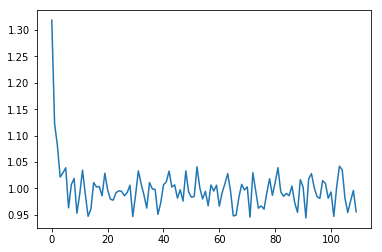

In [0]:
% pylab inline
plot(keff)

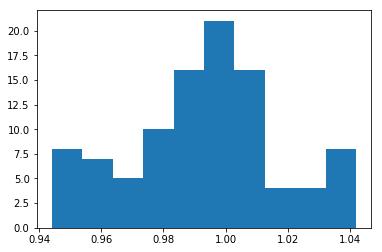

In [0]:
a = hist(keff[11:],bins=10)

La incerteza en el factor de multiplicación es de $200$ pcm ($200\times10^{-5}$). Para reducir la incerteza es necesario aumentar la cantidad de partículas simuladas. Por ejemplo:

In [0]:
run = openmc.Settings()
run.run_mode = "eigenvalue"
run.particles = 10000
run.batches = 110
run.inactive = 10
run.export_to_xml()

In [0]:
!rm summary.h5
!rm statepoint.*.h5
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

In [0]:
estado2 = openmc.StatePoint("statepoint.110.h5")
keff2 = estado2.k_generation

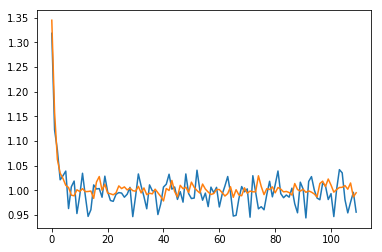

In [0]:
plot(keff)
plot(keff2)

In [0]:
run = openmc.Settings()
run.run_mode = "eigenvalue"
run.particles = 100000
run.batches = 110
run.inactive = 10
run.export_to_xml()

In [0]:
!rm statepoint.110.h5
!rm summary.h5
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

In [0]:
estado3 = openmc.StatePoint("statepoint.110.h5")
keff3 = estado3.k_generation

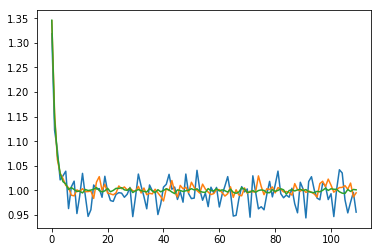

In [0]:
plot(keff)
plot(keff2)
plot(keff3)

[0.99390899 0.00203244]
[1.00136850e+00 6.66424871e-04]
[9.99953576e-01 2.12871919e-04]


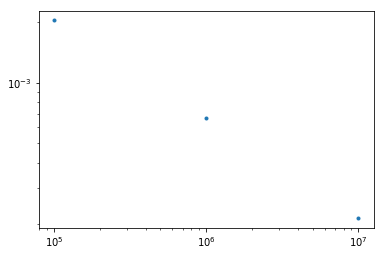

In [0]:
kfinal = estado.k_combined
kfinal2 = estado2.k_combined
kfinal3 = estado3.k_combined
print(kfinal)
print(kfinal2)
print(kfinal3)
loglog([100000,1000000,10000000], [kfinal[1],kfinal2[1],kfinal3[1]],'.')

El resultado neto es que la incerteza en el factor de multiplicación se reduce en un factor de $1/\sqrt{N}$.

## Simulación de fuente fija

Para realizar un cálculo en modo de fuente externa es necesario definir una fuente. La fuente se especifica en el parámetro `.source` del objeto de clase `Settings`. La fuente es un objeto generado con la función `.Source()`, que posee como atributos las distribuciones espaciales, angulares y energéticas de la fuente. Por ejemplo, para definir una fuente isotrópica de $1$ MeV en el origen hacemos:

In [0]:
dist_espacial = openmc.stats.Point(xyz=(0.0, 0.0, 0.0))
dist_angular = openmc.stats.Isotropic()
dist_energetica = openmc.stats.Discrete([1.0e6], [1.0])

fuente = openmc.Source()
fuente.space = dist_espacial
fuente.angle = dist_angular
fuente.energy = dist_energetica

parametros = openmc.Settings()
parametros.source = fuente

Las distribuciones se generan en base al módulo `openmc.stats`. Este módulo posee distintos tipos de distribuciones para las variables energía, posición y dirección, y distribuciones de probabilidad genéricas:

Distribuciones espaciales:

* `openmc.stats.Point()`: distribución delta en un punto del espacio, $\delta(\vec{r}-\vec{r}_0)$.
* `openmc.stats.Box()`: distribución uniformemente distribuida entre un punto (esquina inferior izquierda) y otro (esquina superior derecha).
* `openmc.stats.CartesianIndependent()`: distribución factorizada en distribuciones univariadas para $x$, $y$, $z$.

Distribuciones angulares:
* `openmc.stats.Isotropic()`: distribución isotrópica en la esfera unitaria.
* `openmc.stats.Monodirectional()`: distribución delta en una dirección angular, $\delta(\hat{\Omega}-\hat{\Omega}_0)$.
* `openmc.stats.PolarAzimuthal()`: distribución factorizada en distribuciones univariadas para $\mu = \cos(\theta)$ y $\phi$, respecto a una dirección dada (por defecto, $+z$).

Distribuciones univariadas (que pueden utilizarse también para energía):
* `openmc.stats.Discrete()`: distribución caracterizada por valores discretos con probabilidad asociada.
* `openmc.stats.Uniform()`: distribución con probabilidad constante en un intervalo $[a,b]$.
* `openmc.stats.Tabular()`: distribución continua por trozos con una ley de interpolación (histograma, lin-lin, lin-log, log-lin o log-log`).
* `openmc.stats.Watt()`: distribución de Watt (espectro de fisión: $\chi(E) = C e^{-E/a} \sinh{\sqrt{b E}}$).
* `openmc.stats.Maxwell()`: distribución de Maxwell (distribución térmica: $M(E) = C E e^{-E/kT}$)
* `openmc.stats.Legendre()`: distribución de probabilidad dada por una expansión en polinomios de Legendre.
* `openmc.stats.Mixture()`: distribución discreta en la que los valores son otras distribuciones (similar a `FCEL` en MCNP).

Por ejemplo, la fuga de neutrones de una esfera de agua de radio $5$ cm con una fuente monoenergética :

In [0]:
h2o = openmc.Material()
h2o.add_nuclide("H1", 2.0, "ao")
h2o.add_nuclide("O16", 1.0, "ao")
h2o.set_density("g/cm3", 1)
h2o.add_s_alpha_beta("c_H_in_H2O")

mats = openmc.Materials([h2o])
mats.cross_sections = "/content/nndc_hdf5/cross_sections.xml"
mats.export_to_xml()

esfera = openmc.Sphere(R=5, boundary_type="vacuum")
celda = openmc.Cell(region=-esfera, fill=h2o)
universo = openmc.Universe(cells=[celda])

geom = openmc.Geometry(universo)
geom.export_to_xml()

dist_espacial = openmc.stats.Point(xyz=(0.0, 0.0, 0.0))
dist_angular = openmc.stats.Isotropic()
dist_energetica = openmc.stats.Discrete([1.0e6], [1.0])

fuente = openmc.Source()
fuente.space = dist_espacial
fuente.angle = dist_angular
fuente.energy = dist_energetica

parametros = openmc.Settings()
parametros.source = fuente
parametros.run_mode = "fixed source"
parametros.batches = 100
parametros.particles = 1000
parametros.export_to_xml()

In [0]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

## Fuentes distribuidas en cálculos de criticidad

Ahora que sabemos definir fuentes podemos volver a la simulación de Godiva. Como vimos, el estimador del factor de multiplicación estaba sobreestimado en las primeras generaciones porque la fuente inicial estaba concentrada en la región de máxima importancia (el centro de la esfera). Si, por el contrario, ponemos una fuente inicial distribuida en todo el núcleo la aproximación será por abajo:

In [0]:
umet = openmc.Material()
umet.add_nuclide("U235", 0.9473, 'wo')
umet.add_nuclide("U238", 0.0527, 'wo')
umet.add_nuclide("U234", 0.0102, 'wo')
umet.set_density("g/cm3", 18.74)

mats = openmc.Materials([umet])
mats.cross_sections = "/content/nndc_hdf5/cross_sections.xml"
mats.export_to_xml()

esfera = openmc.Sphere(R=8.74, boundary_type="vacuum")
godiva = openmc.Cell(region = -esfera, fill=umet)
simulacion = openmc.Universe(cells=[godiva])

geom = openmc.Geometry(simulacion)
geom.export_to_xml()

run = openmc.Settings()
run.run_mode = "eigenvalue"
run.particles = 1000
run.batches = 110
run.inactive = 10

fuente = openmc.Source()
dist_espacial = openmc.stats.Box((-9.0, -9.0, -9.0), (+9.0, +9.0, +9.0), only_fissionable=True)
dist_angular = openmc.stats.Isotropic()
fuente.space = dist_espacial
fuente.angle = dist_angular

run.source = fuente

run.export_to_xml()

In [0]:
!rm statepoint.110.h5
!rm summary.h5
openmc.run()

rm: cannot remove 'statepoint.110.h5': No such file or directory

                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%

0

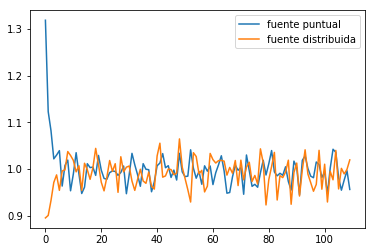

In [0]:
estado4 = openmc.StatePoint("statepoint.110.h5")
keff4 = estado4.k_generation
plot(keff, label="fuente puntual")
plot(keff4, label="fuente distribuida")
legend()